In [169]:
import torch
import torch.nn as nn
import math
import numpy
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles, make_moons, make_blobs, load_iris
from sklearn.model_selection import train_test_split
import torchmetrics
import seaborn as sns
DEVICE = 'cuda' if torch.cuda.is_available() else (torch.device('mps') if torch.backends.mps.is_available() else 'cpu')
DEVICE

device(type='mps')

In [170]:
data = load_iris()
X_np,y_np = data.data, data.target
X, y = torch.from_numpy(X_np).type(torch.float32), torch.from_numpy(y_np).type(torch.float32)
X_np.shape, y_np.shape, y_np

((150, 4),
 (150,),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))

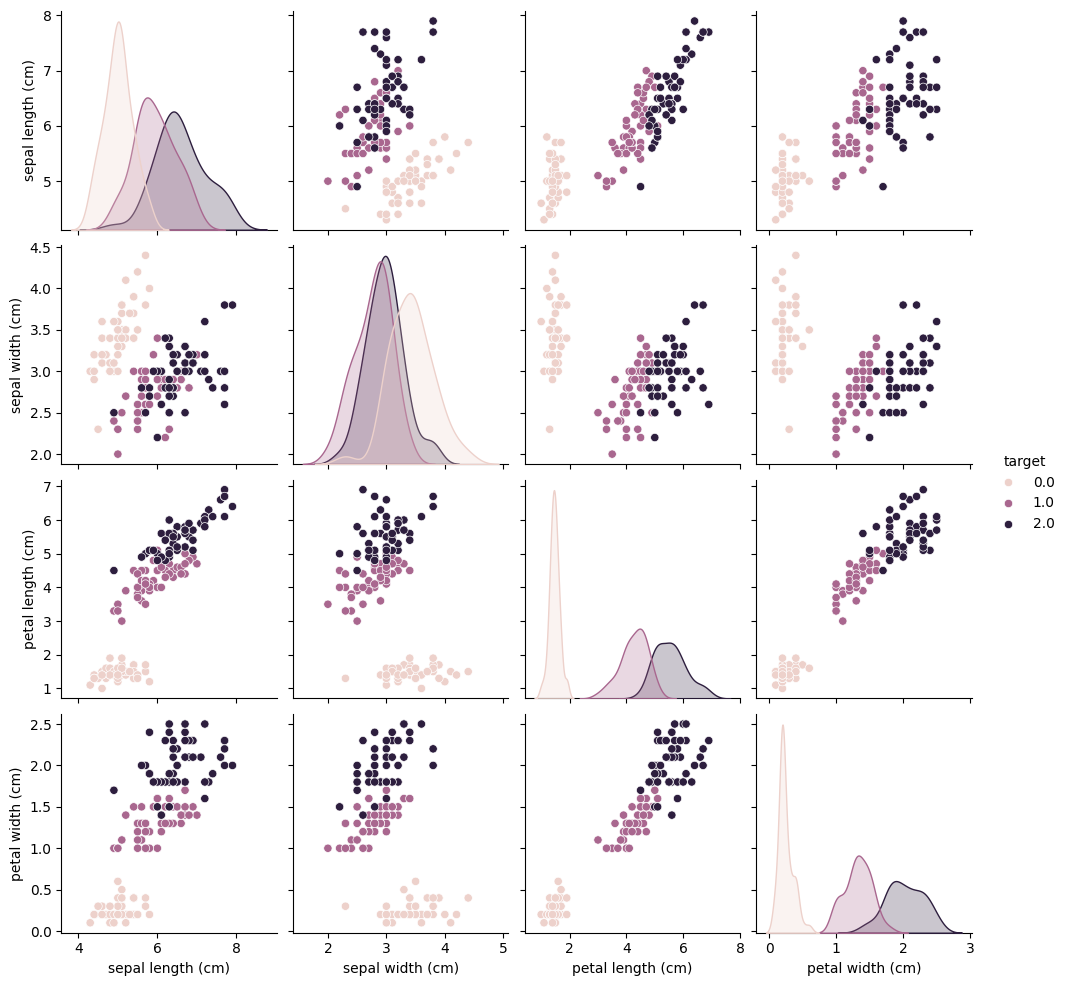

In [171]:
df = pd.DataFrame(X_np, columns=data.feature_names)
df['target'] = y

sns.pairplot(df, hue='target', diag_kind='kde')
plt.show()

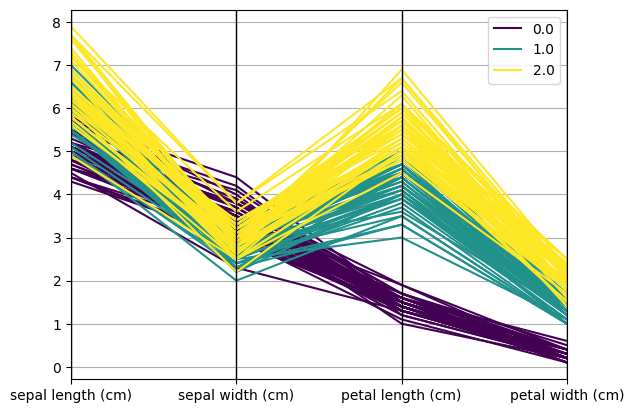

In [172]:
from pandas.plotting import parallel_coordinates
parallel_coordinates(df, class_column='target', colormap='viridis')
plt.show()

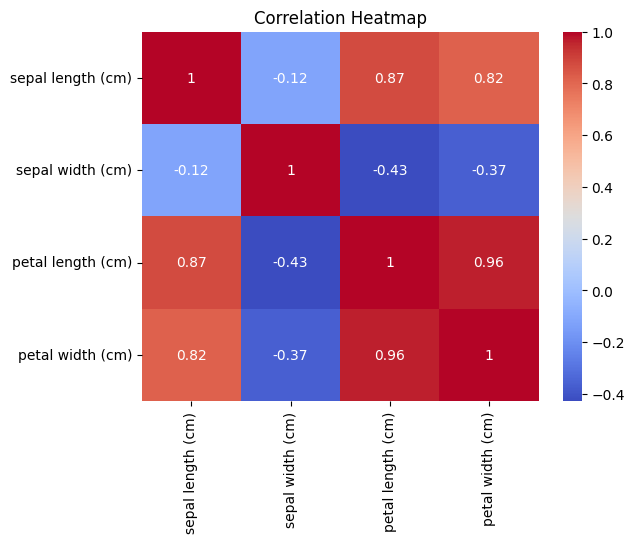

In [173]:
sns.heatmap(df.iloc[:,:-1].corr(),annot=True,cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [174]:
NUM_CLASSES = 3
NUM_FEATURES = 4
RAND_SEED = 42


X_train_cpu, X_test_cpu, y_train_cpu, y_test_cpu = train_test_split(X,y,test_size=0.4, random_state=RAND_SEED)
X_train = X_train_cpu.to(DEVICE).type(torch.float32)
X_test = X_test_cpu.to(DEVICE).type(torch.float32)
y_train = y_train_cpu.to(DEVICE).type(torch.float32)
y_test = y_test_cpu.to(DEVICE).type(torch.float32)



In [175]:
class MultiClassClassifier(nn.Module):
    def __init__(self, input_features : int, output_features : int, hidden_units:int = 10):
        super().__init__()
        self.layerstack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        return self.layerstack(x)



model = MultiClassClassifier(input_features=NUM_FEATURES, output_features=NUM_CLASSES, hidden_units=10).to(DEVICE)
model.state_dict

<bound method Module.state_dict of MultiClassClassifier(
  (layerstack): Sequential(
    (0): Linear(in_features=4, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)>

In [176]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.03)

In [177]:
y_logits = model.forward(X_train[:5])
y_pred = torch.softmax(y_logits, dim=1)
maxxed = torch.argmax(y_pred, dim = 1)
y_logits, y_pred, maxxed

(tensor([[ 0.0375, -0.1104,  0.4208],
         [ 0.0665,  0.1856,  0.2188],
         [ 0.0501,  0.1385,  0.2261],
         [ 0.0498,  0.1690,  0.2202],
         [ 0.0497, -0.0537,  0.3762]], device='mps:0',
        grad_fn=<LinearBackward0>),
 tensor([[0.3003, 0.2590, 0.4406],
         [0.3039, 0.3423, 0.3539],
         [0.3044, 0.3326, 0.3630],
         [0.3019, 0.3401, 0.3580],
         [0.3042, 0.2743, 0.4216]], device='mps:0', grad_fn=<SoftmaxBackward0>),
 tensor([2, 2, 2, 2, 2], device='mps:0'))

In [178]:
epochs = 500
torch.manual_seed(RAND_SEED)

train_losses = []

for epoch in range(epochs):
    model.train()

    y_logits = model.forward(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_train)
    train_losses.append(loss.cpu().detach().numpy())
    accuracy = torchmetrics.functional.accuracy(preds=y_pred, target=y_train,task='multiclass', num_classes=NUM_CLASSES)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if epoch % int(epochs/10) == 0:
        model.eval()
        test_logits = model.forward(X_test)
        y_test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_test)
        test_accuracy = torchmetrics.functional.accuracy(preds=y_test_pred, target=y_test,task='multiclass', num_classes=NUM_CLASSES)

        print(f"Epoch {epoch} | Train Loss: {loss:.5f} | Train Accuracy: {accuracy:.5f} || Test Loss: {test_loss:.5f} | Test Accuracy: {test_accuracy:.5f}")


Epoch 0 | Train Loss: 1.09551 | Train Accuracy: 0.35556 || Test Loss: 1.10473 | Test Accuracy: 0.30000
Epoch 50 | Train Loss: 0.85202 | Train Accuracy: 0.65556 || Test Loss: 0.83674 | Test Accuracy: 0.68333
Epoch 100 | Train Loss: 0.51710 | Train Accuracy: 0.80000 || Test Loss: 0.45634 | Test Accuracy: 0.81667
Epoch 150 | Train Loss: 0.39109 | Train Accuracy: 0.92222 || Test Loss: 0.33021 | Test Accuracy: 0.93333
Epoch 200 | Train Loss: 0.29661 | Train Accuracy: 0.94444 || Test Loss: 0.24452 | Test Accuracy: 0.95000
Epoch 250 | Train Loss: 0.38128 | Train Accuracy: 0.75556 || Test Loss: 0.35520 | Test Accuracy: 0.76667
Epoch 300 | Train Loss: 0.26249 | Train Accuracy: 0.88889 || Test Loss: 0.22066 | Test Accuracy: 0.90000
Epoch 350 | Train Loss: 0.21865 | Train Accuracy: 0.92222 || Test Loss: 0.17399 | Test Accuracy: 0.93333
Epoch 400 | Train Loss: 0.18008 | Train Accuracy: 0.93333 || Test Loss: 0.13319 | Test Accuracy: 0.95000
Epoch 450 | Train Loss: 0.15130 | Train Accuracy: 0.94444 

Text(0, 0.5, 'Cross Entropy Loss')

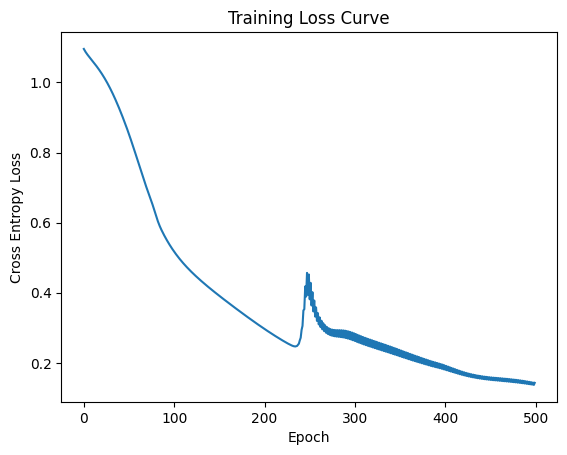

In [179]:
plt.plot([i for i in range(epochs)], train_losses, label = "Train Loss")
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")